## Homogeneous sphere collapse

I hereby present the results of the simulations done with `nbody_sh1` and `treecode` by Barnes and Hut and make a few considerations about the physics of the problem.


## Initial Data
To better understand the choice of our initial datas, we first have to show the conversion we used to go from Internal Units to the cgs system.<br>
From the definition of *centripetal force*<br><br>
$$ 
f_\text{cp} = \dfrac{v^2}{r} = \dfrac{GM}{r^2}
$$
<br>
we define the following *adimensional quantity* for our conversion

$$
\left(\dfrac{GM}{rv^2}\right)_\mathrm{iu} = \left(\dfrac{GM}{rv^2}\right)_\mathrm{cgs} 
$$
<br>

I decided to set a globular cluster with mass $M = 10^5 \ M_\odot$ and typical radius $r = 10$ pc, therefore we can calculate the values of $v$ 

$$
\dfrac{m_\text{cgs}}{m_\text{iu}} = 2 \times 10^{38}\ \mathrm{g} \qquad \dfrac{r_\text{cgs}}{r_\text{iu}} = 3 \times 10^{19} \ \mathrm{cm}
$$

In the cgs units $G = 6.67 \times 10^{-8}$, so the velocity will be

$$
\dfrac{v_\text{cgs}}{v_\text{iu}} = 6 \times 10^{5}\ \mathrm{cm\ s^{-1}} \approx 6\ \mathrm{km\ s^{-1}}
$$

In addition to what was requested by the direct Nbody code, the tree code requires two parameters:
- $\theta_\text{acc}$ is the accuracy parameter, it is defined as the lowest distance two particles can have in our simulation. It is related to the numerical approximation error on the interacting force between particles, the formula is
    $$ 2\theta_\text{acc} = \dfrac{\Delta F_i}{F_i} $$

- $\varepsilon$ is the softening parameter, it's defined as
    
    $$\varepsilon = \bigg(\dfrac{V}{N}\bigg)^{\frac{1}{3}}$$
    
    it defines a dampening term which enters in the equation of the force as
    
    $$ |f_{ij}| = \text{G}\ \dfrac{m_i}{|\vec{r_i} - \vec{r_j}|^2 + \varepsilon^2}\$$
    
    we will use it to eliminate the strong force interactions that could occour in the collapse.<br>
    
- $dt$ is the timestep of integration, a lower value gives a more accurate estimate of the particles positions

### Intepreting the data
The initial data set that we have chosen to simulate a pl-collapsing sphere is the following, expressed in internal units:
We have set up the total time of the simulation to be of 50 IU (this will vary) and the ouput to be printed every 0.01 UI, to have enough data to be confronted with the theoretical model. 

### SH1 or Treecode?
The theory suggests that since SH1 is a direct nbody code, the computation times should be larger but the forces are calculated more accurately. We can show that the computation time goes as $O(N^2)$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML

plt.style.use('../../sim.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [2]:
comp_t = [0, 3.3, 35.4, 47.2, 166, 646, 16*60, 47*60]
N_particles = [10, 50, 100, 120, 200, 300, 400, 500]

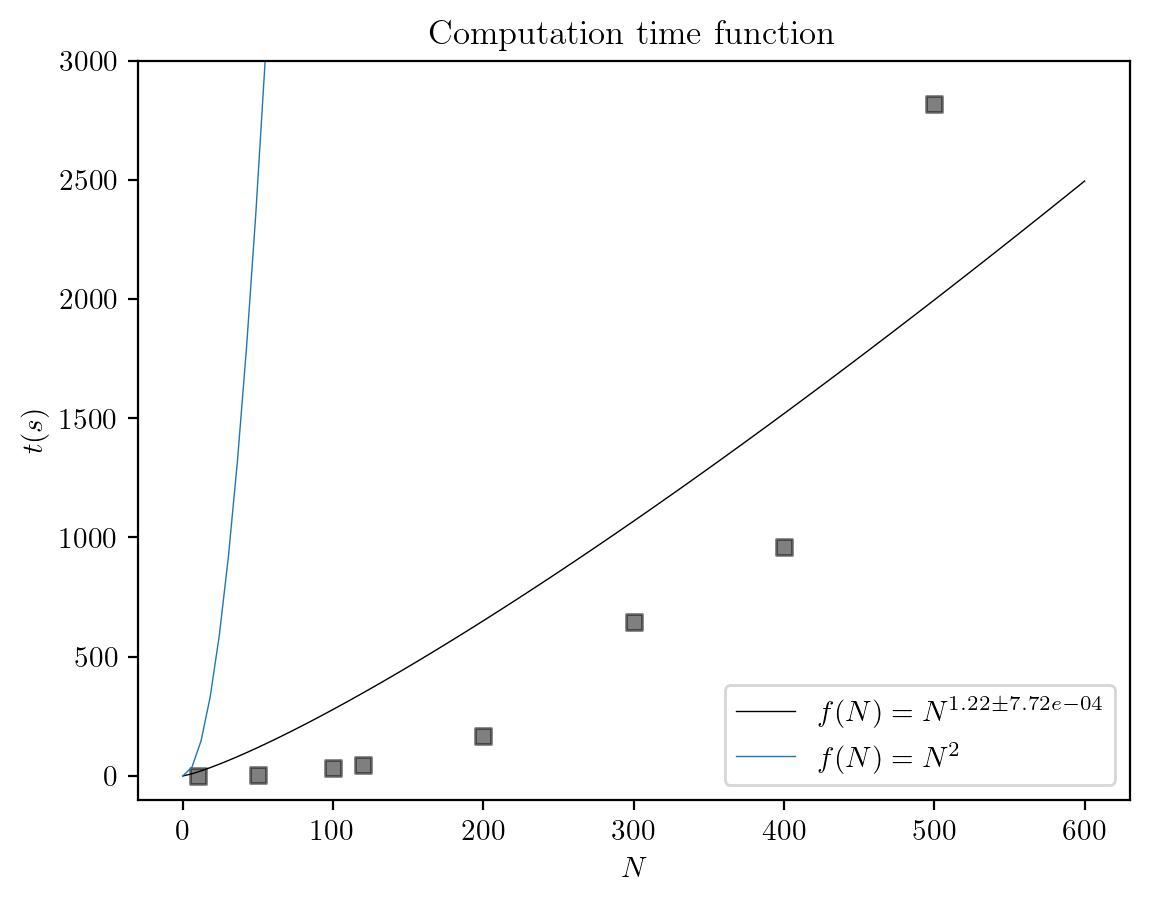

In [3]:
from scipy import optimize

x = np.linspace(0,600,100)

def exp(x, a):
    return x**a

a_start = 1 #starting guess
param, param_cov = optimize.curve_fit(exp, N_particles, comp_t, p0=2)
y_pred = exp(x, param[0])
y_th = exp(x, 2)


plt.scatter(N_particles, comp_t, color= 'k', marker='s', alpha=.5)
plt.plot(x, y_pred, lw=.5, color='k', label=fr"$f(N) = N^{{{param[0]:.2f} \pm {param_cov[0,0]:.2e}}}$")
plt.plot(x, y_th, lw=.5, label=fr"$f(N) = N^2$")
plt.title('Computation time function')
plt.xlabel(r'$N$')
plt.ylim(-100,3e3)
plt.ylabel(r'$t(s)$')
plt.legend();

### Loading data

In [4]:
import sys
sys.path.insert(1, '../')
import gdsam

In [5]:
N='1e4'

inp = f'../../data/outputs/hom_sph_{N}.txt'
pl = gdsam.plotter()
pl.get_data_tree(inp)

Loaded 1e+04 particles


In [6]:
from IPython.display import Video

Video(f'../media/hom_sph_{N}.mp4', width=600)

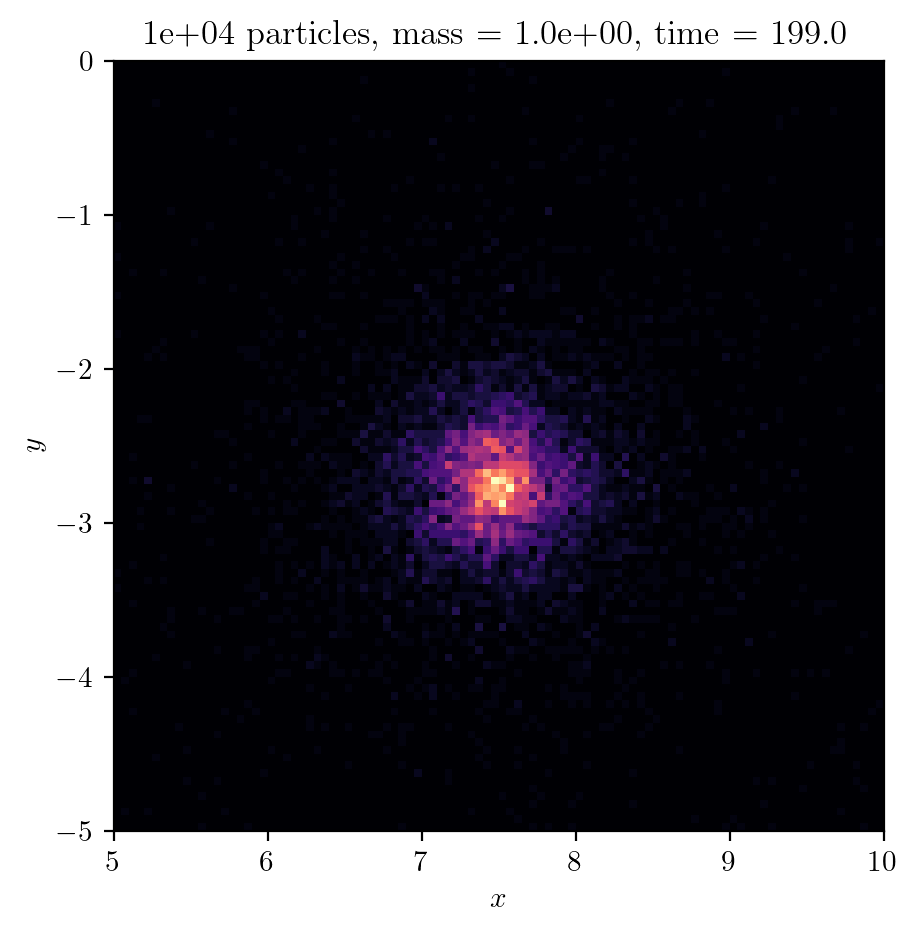

In [7]:
num = len(pl.t)-1
pl.positions_heatmap(num, 'xy', x_min = 5, y_min = -5, l=5);

### Conversion to physical units
I now show how one can move from IU to the physical units we will use from now on.

$1\ r_\mathrm{IU} = 1 \ \mathrm{pc}$ $\qquad$ $1\ M_\mathrm{IU} = 10^5 M_\odot$ $\qquad$ $1\ v_\mathrm{IU} = 6 \mathrm{km/s}$ $\qquad$ $t_\mathrm{IU} = r_\mathrm{IU}/v_\mathrm{IU} = (3\times 10^{13})/ 6\  s = 0.14\ \mathrm{Myr}$

In [8]:
conv = {}
conv['m'] = 1e5 #conversion factor for mass
conv['pos'] = 1 #conversion factor for radius
conv['vel'] = 6 #conversion factor for v
conv['t'] = 0.14 #conversion factor for time

pl.convert_values(conv)

In [439]:
#converting the gravitational constant
G = 1*conv['m']**(-1)*conv['pos']**3*conv['t']**(-2)
print(G)

0.000510204081632653


### CoM

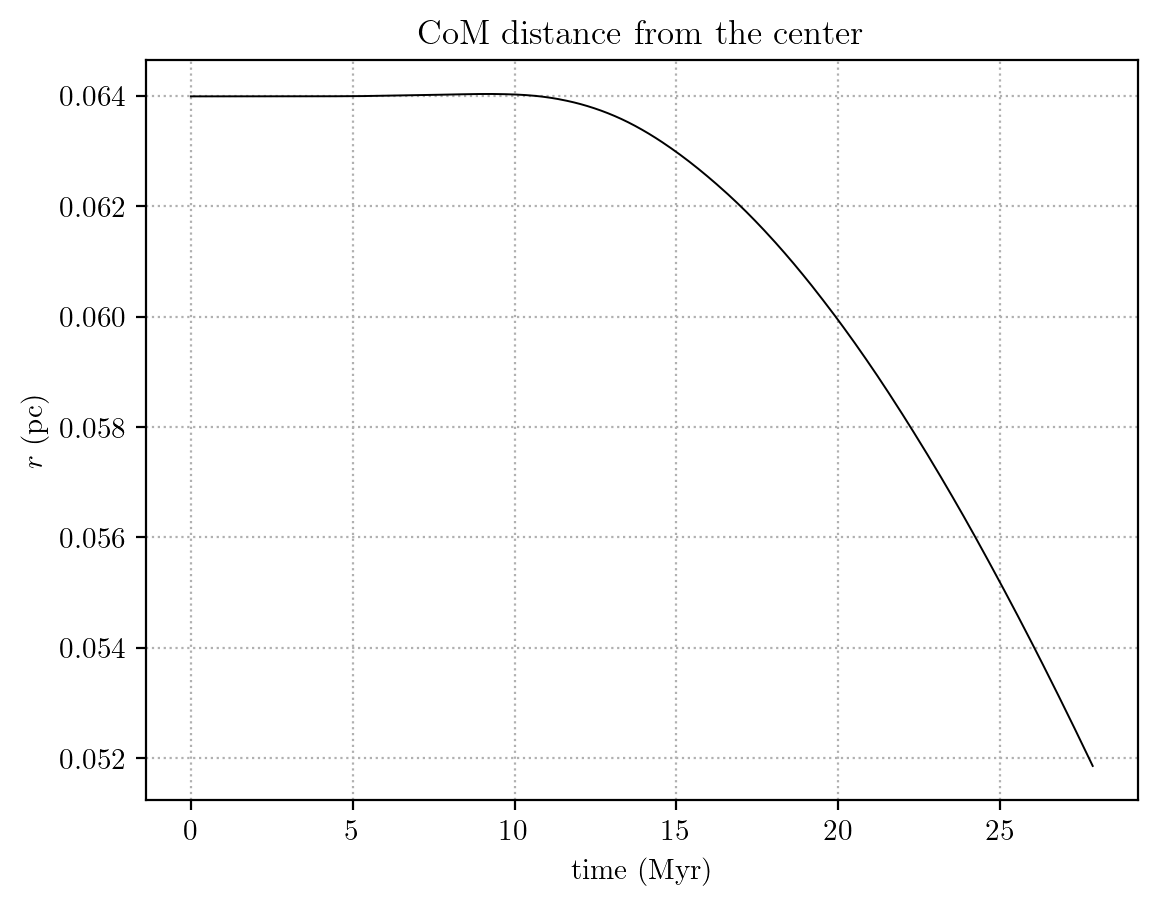

In [440]:
r_cm = gdsam.distance(pl.x_cm, pl.y_cm, pl.z_cm, 0, 0, 0)

plt.plot(pl.t, r_cm, lw=.7, c='k')

plt.title(r'CoM distance from the center')
plt.ylabel(r'$r$ (pc)')
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel(r'time (Myr)')
plt.grid();


Should the center of mass position be fixed? Well, the density is not entirely homogeneous due to the discretization. Also, if you have a computation error on the forces, the center of mass will not experience any net force but it can acquire a constant velocity on some axis, due to the error on the position propagating.

### How is the density distributed?

In [441]:
steps = 50
scan = np.linspace(.5, 10, steps)

d = np.array([pl.rho_mean_sphere(a)[0] for a in scan])

We start with a Normal distribution

Relative deviation error: 0.14


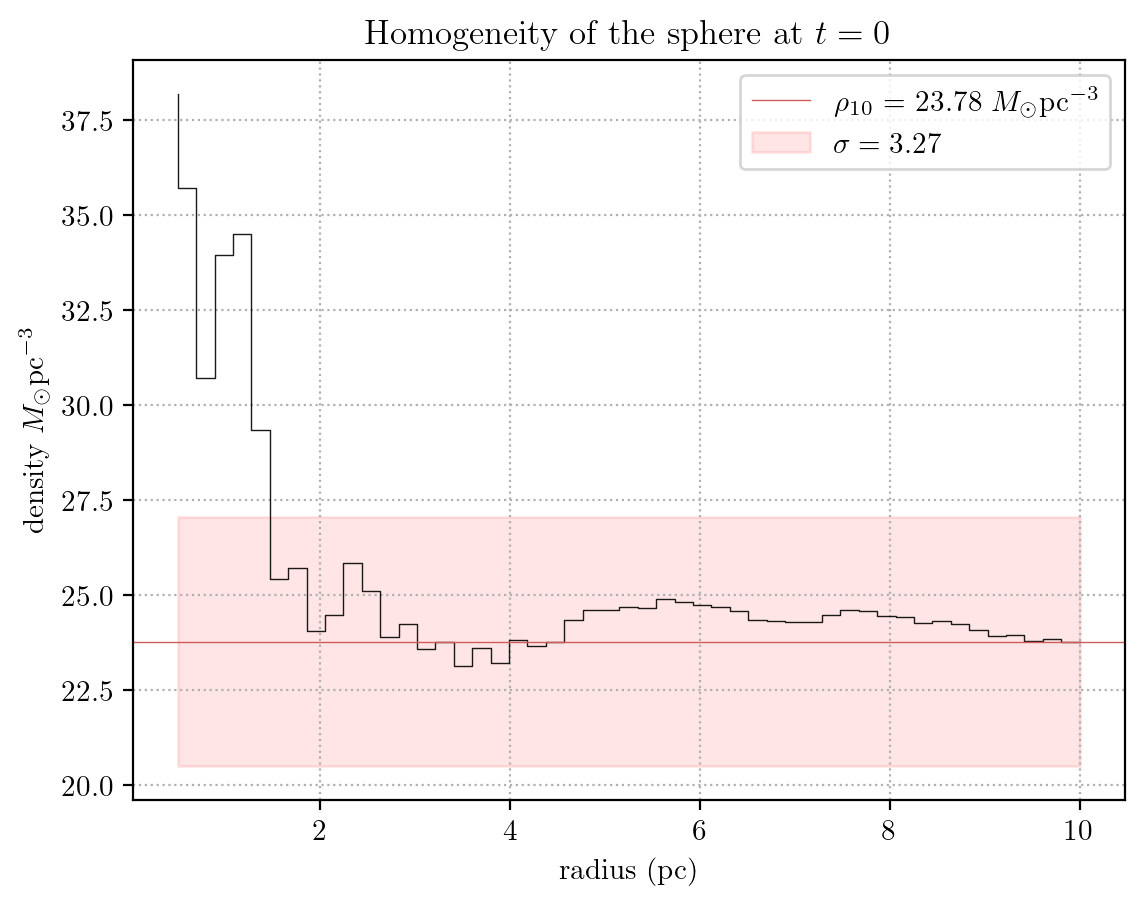

In [442]:
# Normal distribution
plt.step(scan, d, c='k', lw=.5, alpha=.9)
plt.axhline(y=pl.rho_mean_sphere(10)[0],
            c='indianred', lw=.5,
            label=fr'$\rho_{{10}}$ = {d[-1]:.2f} $M_\odot\mathrm{{pc^{{-3}}}}$')
plt.fill_between(scan,
                 y1=pl.rho_mean_sphere(10)[0]-np.std(d), 
                 y2=pl.rho_mean_sphere(10)[0] + np.std(d),
                  color='r', alpha=.1, label=fr'$\sigma = {np.std(d):.2f}$')
plt.title(r'Homogeneity of the sphere at $t=0$')
plt.ylabel(r'density $M_\odot\mathrm{pc^{-3}}$')
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel(r'radius (pc)')
plt.grid()
plt.legend()


print(f'Relative deviation error: {np.std(d)/d[-1]:.2f}')

Watching closely you can tell that the density resembles a Poisson distirbution. So we can calculate the expectation value and the error using that distribution instead. In the range (2,10) rho and sigma make sense just because of the CLT (central limi theorem) that ensures that when you have high numbers, each distribution tends to a Normal distribution.

We know the true value of the density of a truncated homogeneous sphere.

$$
    \rho_0 = \dfrac{M}{V} = \dfrac{1}{\dfrac{4}{3}\pi a^3}
$$

We chose the radius to be 10 parsecs and the mass to be $10^5\ M_\odot$ therefore

In [443]:
rho_0 = 10**5/(4/3*np.pi*10**3)
print(f'{rho_0:.2f}')

23.87


This is the true value of the density. Now if the density is Poisson distributed, then the expectation value and error will be

$$\mathrm E(x) = \lambda \qquad \sigma(x) = \sqrt{\lambda}$$

With $\lambda = \lambda(r)$ average number of events per unit time, so the number of particles that fall into the shell with that radius $N(r)$. To convert this information into the density we can say 

$$N(r) = \dfrac{\rho(r)\ V(r)}{M_\mathrm{tot}}$$

And the error, since the volume is exact

$$\sigma(N) = \dfrac{\sigma(\rho)\ V(r)}{M_\mathrm{tot}}$$

Therefore for the density

$$\rho(r) =  \dfrac{N(r)\ M_\mathrm{tot}}{V(r)} \qquad \sigma(\rho) =  \dfrac{\sigma(N)\ M_\mathrm{tot}}{V(r)} = \dfrac{\sqrt{N}\ M_\mathrm{tot}}{V(r)} $$

In [444]:
counts = []
for r_ in scan:
    mask = pl.r[:,0] < r_
    counts.append(len(pl.m[mask]))

counts = np.array(counts)
print(counts)

[   2    5    9   18   30   39   49   69   87  116  157  192  226  280
  328  394  453  541  618  731  832  951 1104 1258 1411 1582 1757 1967
 2166 2379 2606 2841 3074 3345 3630 3936 4289 4659 5013 5364 5754 6133
 6577 7005 7431 7871 8384 8855 9423 9962]


Relative deviation error: 2.39e-02


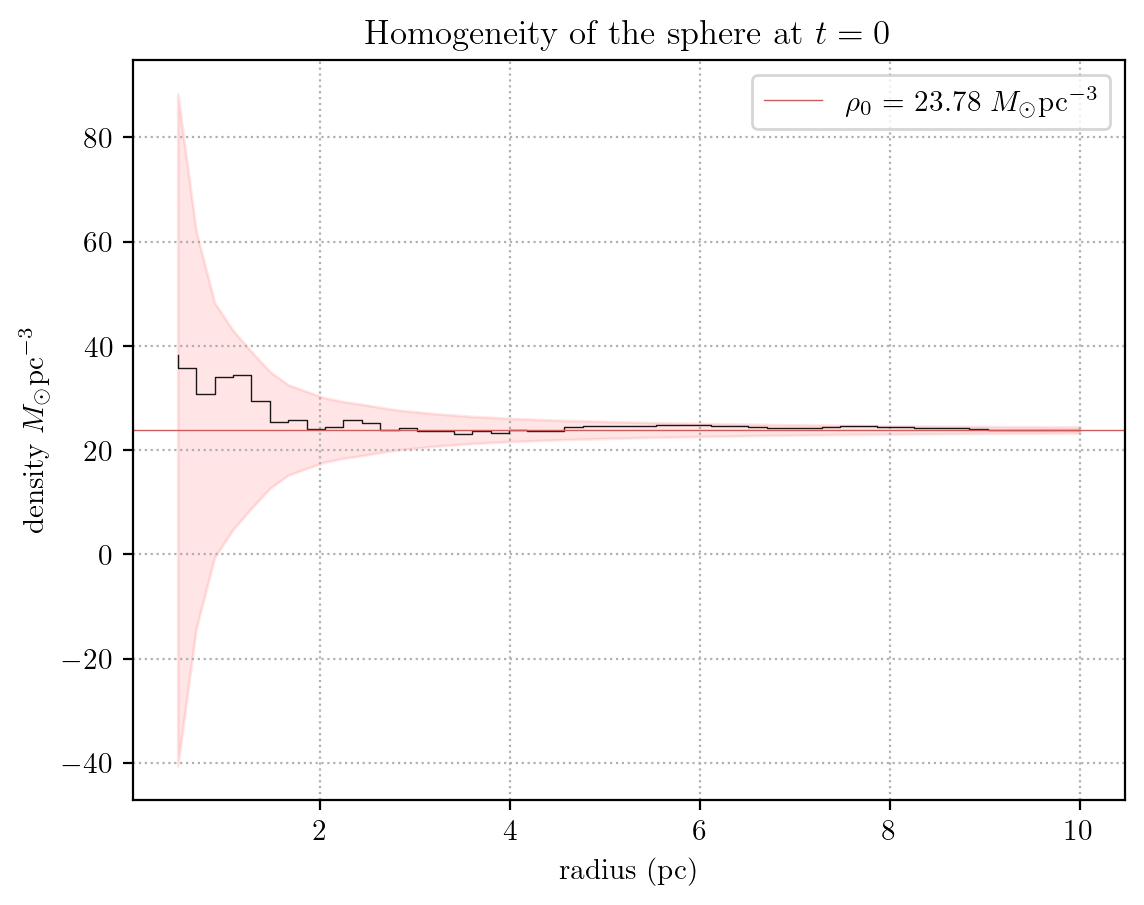

In [447]:
# Poisson distribution : not working
mu = rho_0
sigma = mu*np.sqrt(counts)/(4/3*np.pi*(scan)**3) #density in each shell over the volume of the shell


plt.step(scan, d, c='k', lw=.5, alpha=.9)
plt.axhline(y=mu, c='indianred', lw=.5,
            label=fr'$\rho_0$ = {d[-1]:.2f} $M_\odot\mathrm{{pc^{{-3}}}}$')
plt.fill_between(scan, mu - sigma, mu + sigma,
                 color='r', alpha=.1, label=fr'')
plt.title(r'Homogeneity of the sphere at $t=0$')
plt.ylabel(r'density $M_\odot\mathrm{pc^{-3}}$')
#plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel(r'radius (pc)')
plt.grid()
plt.legend()


print(f'Relative deviation error: {sigma[-1]/d[-1]:.2e}')

### Free fall time

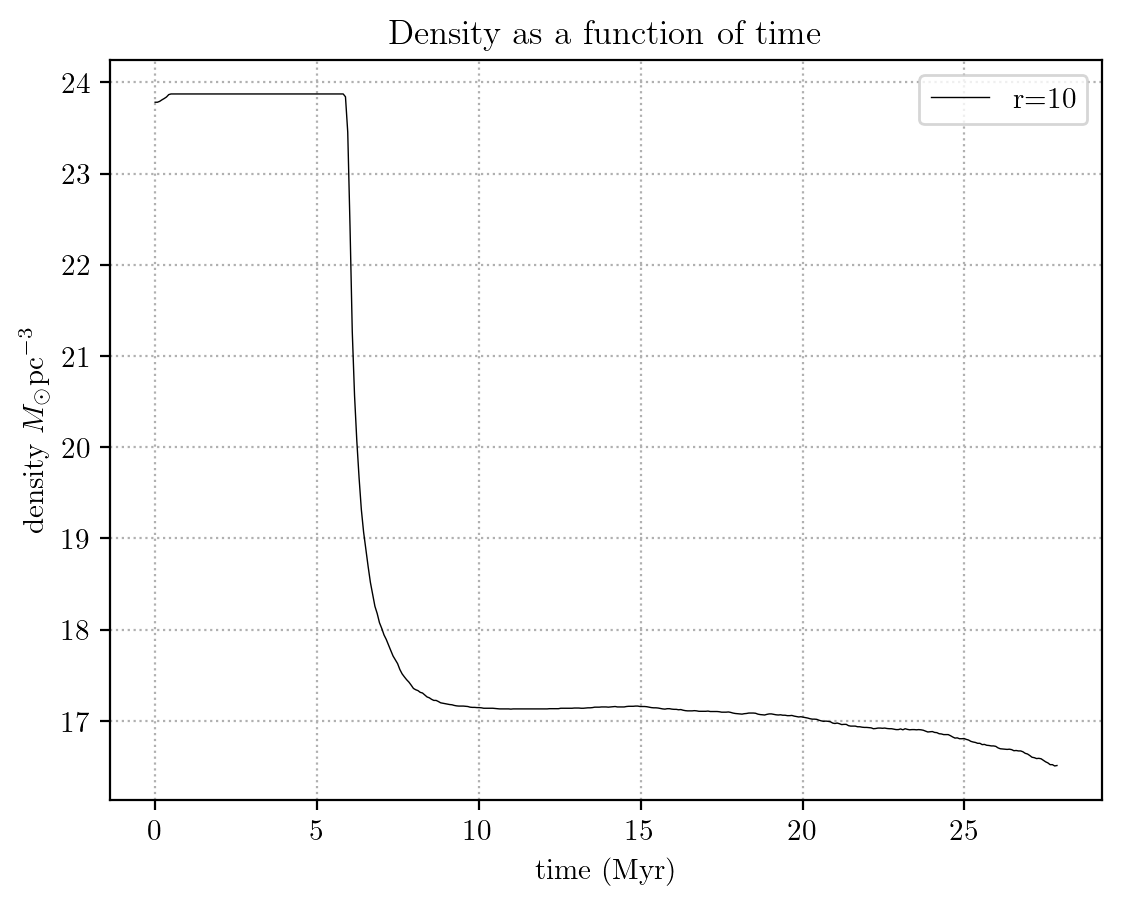

In [448]:
a=10
plt.plot(pl.t, pl.rho_mean_sphere(a), label=fr'r={a}', lw=.5, c='k')

plt.xlabel('time (Myr)')
plt.title('Density as a function of time')
plt.ylabel(r'density $M_\odot \mathrm{pc^{-3}}$')
plt.grid()
plt.legend();

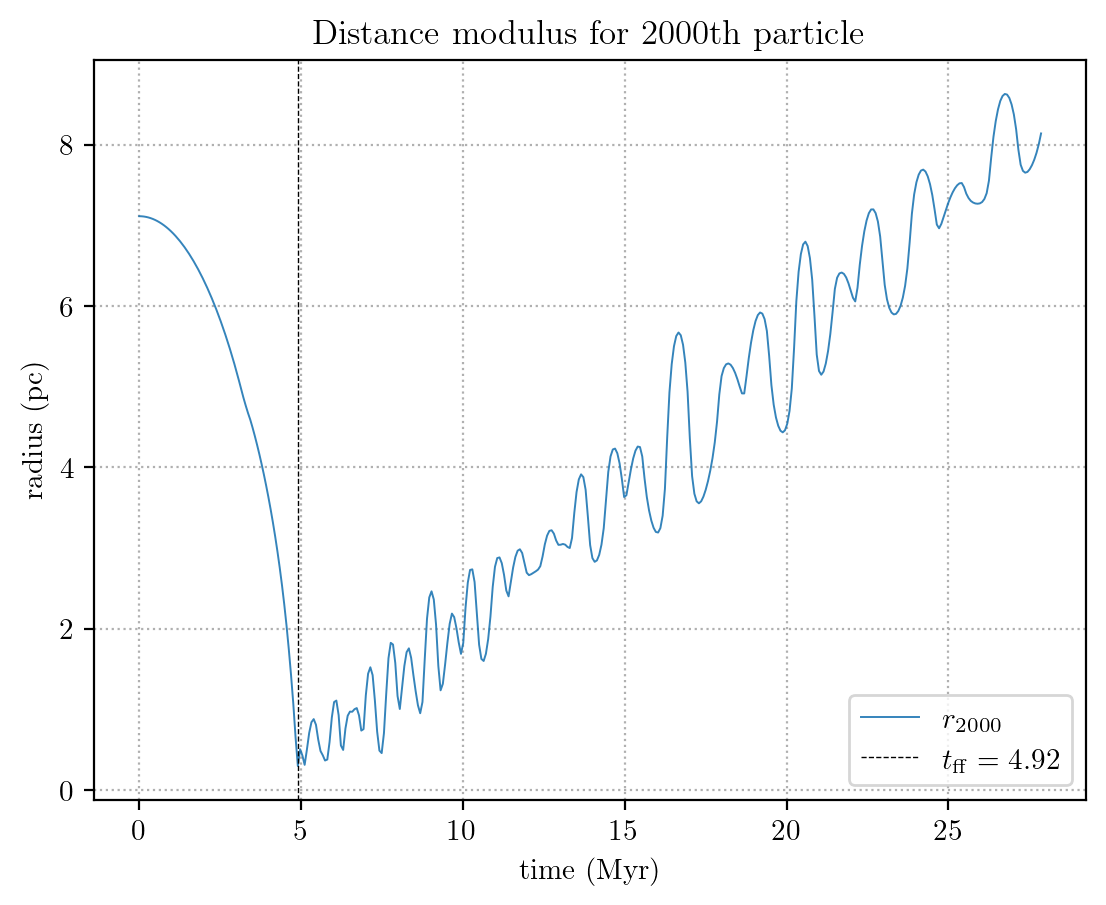

In [449]:
i=int(2e3)
plt.plot(pl.t, pl.r[i,:],lw=.7, alpha=.9,
         label=fr'$r_{{{i}}}$')

t_ff = np.sqrt(3*np.pi/(32*G*rho_0))
plt.axvline(t_ff,ymin=0,ymax=20, ls='--', c='k', lw=.5, label=fr'$t_\mathrm{{ff}} = {t_ff:.2f}$')

plt.xlabel('time (Myr)')
plt.title(fr'Distance modulus for {i}th particle')
plt.ylabel(r'radius (pc)')
plt.grid()
plt.legend();

In [471]:
t_ff = np.sqrt(3*np.pi/(32*G*rho_0))

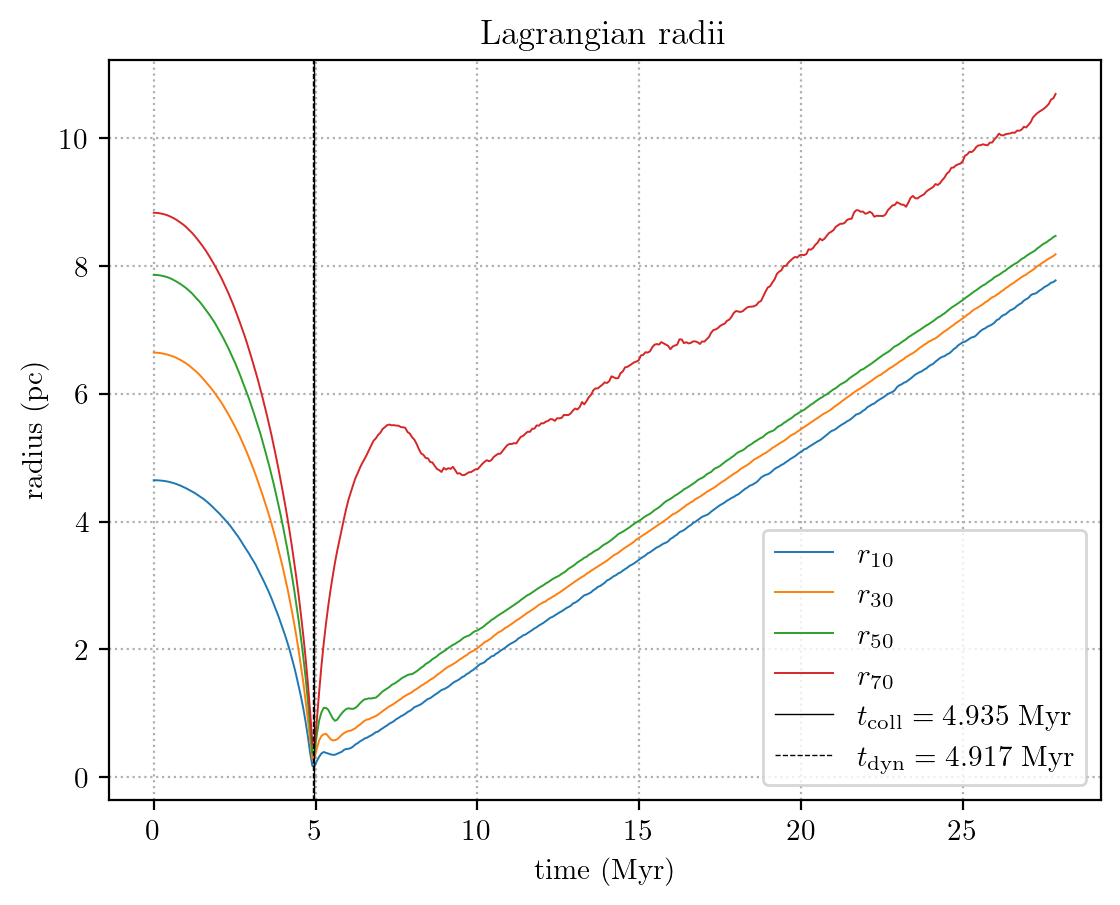

In [472]:
q = np.arange(.1,.9,.2)
t_i = [] #collapse time

colors = plt.cm.tab10(np.arange(0,len(q)))

for q_,c in zip(q,colors):
    r_ = pl.l_radii(q_)
    
    plt.plot(pl.t, r_,lw=.7, c=c,
             label=fr'$r_{{{q_*100:n}}}$')
    
    t_ = pl.t[r_ == np.min(r_)]
    t_i.append(t_)
        

t_coll = np.average(t_i)
plt.axvline(t_coll, ymin=0, ymax=25, lw=.5, ls='-', c='k',
            label = fr'$t_\mathrm{{coll}} = {t_coll:.3f}$ Myr') 
plt.axvline(t_ff, ymin=0, ymax=25, lw=.5, ls='--', c='k',
            label = fr'$t_\mathrm{{dyn}} = {t_ff:.3f}$ Myr')    

plt.xlabel('time (Myr)')
plt.title('Lagrangian radii')
plt.ylabel('radius (pc)')
plt.grid()
plt.legend(loc='lower right')

plt.show()

Let's compare it with the analytical function

In [473]:
def t_ff_(r):
    r_0 = r[0]
    r = np.clip(r,0,r_0)
    return np.sqrt(3/(8*np.pi*G*rho_0))*(np.pi/2 - np.arcsin(np.sqrt(r/r_0)) + np.sqrt(r/r_0)*(np.sqrt(1-r/r_0)))

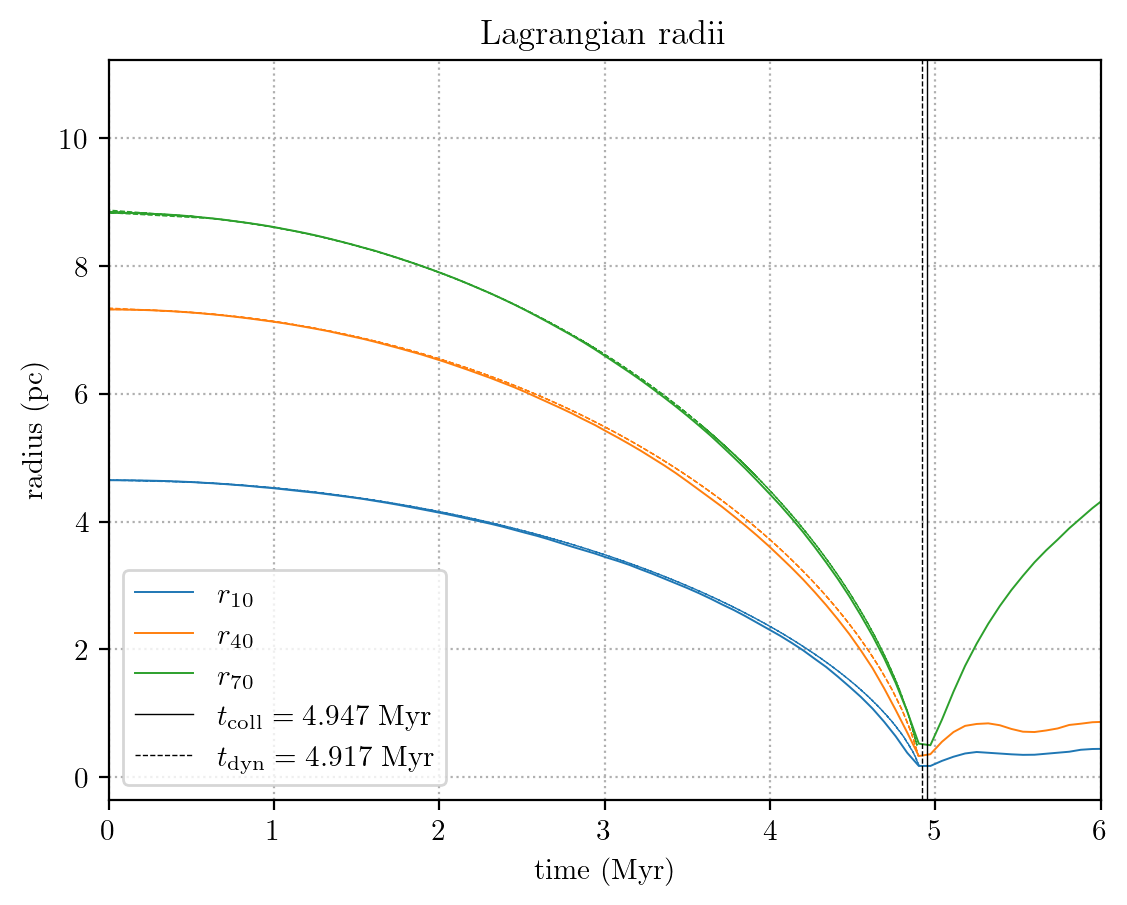

In [478]:
q = np.arange(.1,.9,.3)
t_i = [] #collapse time

colors = plt.cm.tab10(np.arange(0,len(q)))

for q_,c in zip(q,colors):
    r_ = pl.l_radii(q_)
    
    plt.plot(pl.t, r_,lw=.7, c=c,
             label=fr'$r_{{{q_*100:n}}}$')
    plt.plot(t_ff_(r_), r_, c=c, ls='--')
    
    t_ = pl.t[r_ == np.min(r_)]
    t_i.append(t_)
        

t_coll = np.average(t_i)
plt.axvline(t_coll, ymin=0, ymax=25, lw=.5, ls='-', c='k',
            label = fr'$t_\mathrm{{coll}} = {t_coll:.3f}$ Myr') 
plt.axvline(t_ff, ymin=0, ymax=25, lw=.5, ls='--', c='k',
            label = fr'$t_\mathrm{{dyn}} = {t_ff:.3f}$ Myr')    

plt.xlabel('time (Myr)')
plt.title('Lagrangian radii')
plt.ylabel('radius (pc)')
plt.xlim(0,6)
plt.grid()
plt.legend()

plt.show()

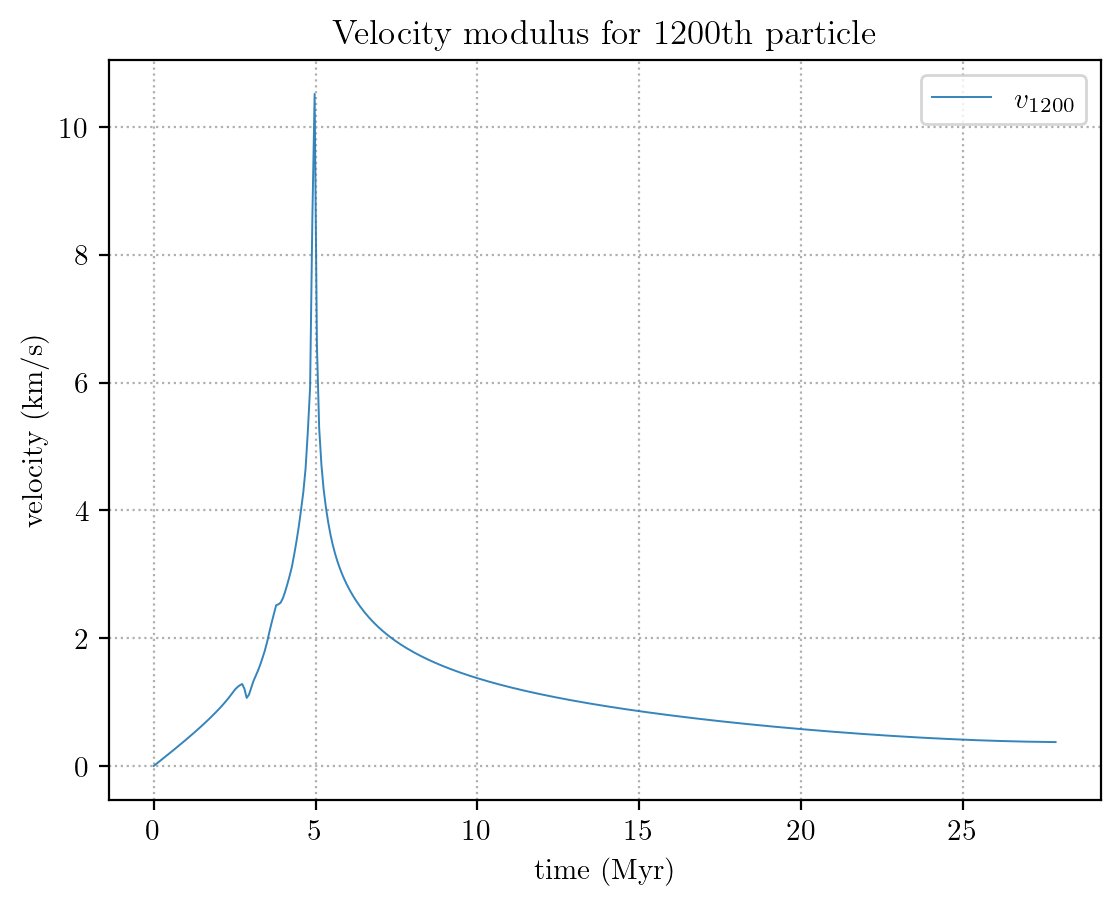

In [479]:
i=int(1.2e3)
plt.plot(pl.t, pl.v[i,:],lw=.7, alpha=.9,
         label=fr'$v_{{{i}}}$')

plt.xlabel('time (Myr)')
plt.title(f'Velocity modulus for {i}th particle')
plt.ylabel('velocity (km/s)')
plt.grid()
plt.legend();

### Remnant study
Depending on the initial conditions it is possible to obtain a bound structure or not, see the conclusions for more insights. This time we get an unstable distribution, nevertheless we would like to characterize the resulting distribution at $t = 3T_\mathrm{dyn}$

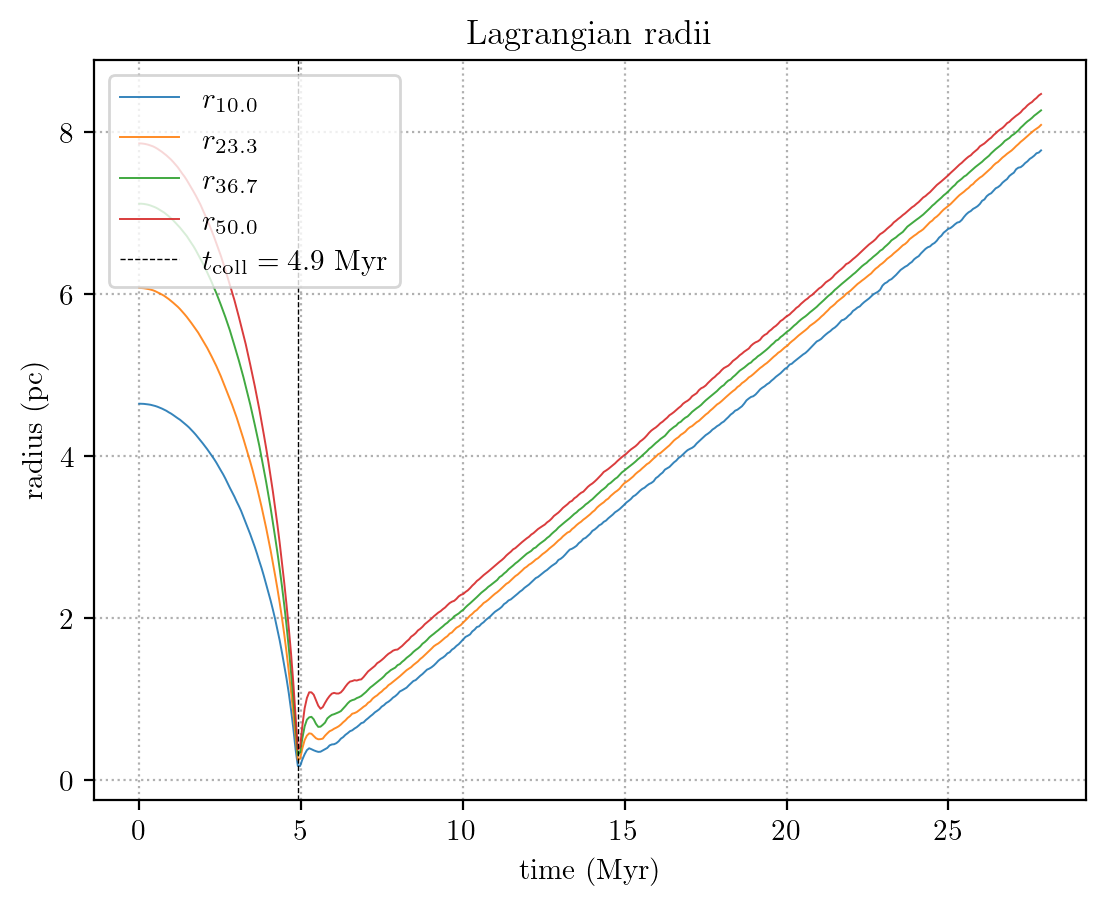

In [480]:
q = np.linspace(0.1,.5,4)
t_i = [] #collapse time

for q_ in q:
    plt.plot(pl.t, pl.l_radii(q_),lw=.7, alpha=.9,
             label=fr'$r_{{{q_*100:.1f}}}$')
    
    t_i.append(pl.t[pl.l_radii(q_) == np.min(pl.l_radii(q_))])

t_coll = np.average(t_i)
plt.axvline(t_coll, ymin=0, ymax=25, lw=.5, ls='--', c='k',
            label = fr'$t_\mathrm{{coll}} = {t_coll:.1f}$ Myr')    

plt.xlabel('time (Myr)')
plt.title('Lagrangian radii')
plt.ylabel('radius (pc)')
plt.grid()
plt.legend(loc='upper left');

It seems like the structure was going to be bound but instead it lead to an unstable equilibrium, or so it seems. We know the new structure has a velocity so it's normal that over time the lagrangian radii become bigger and bigger with respect to the origin, what we can do is study the lagrangian radii in the reference frame commoving with the remnant's center of mass.

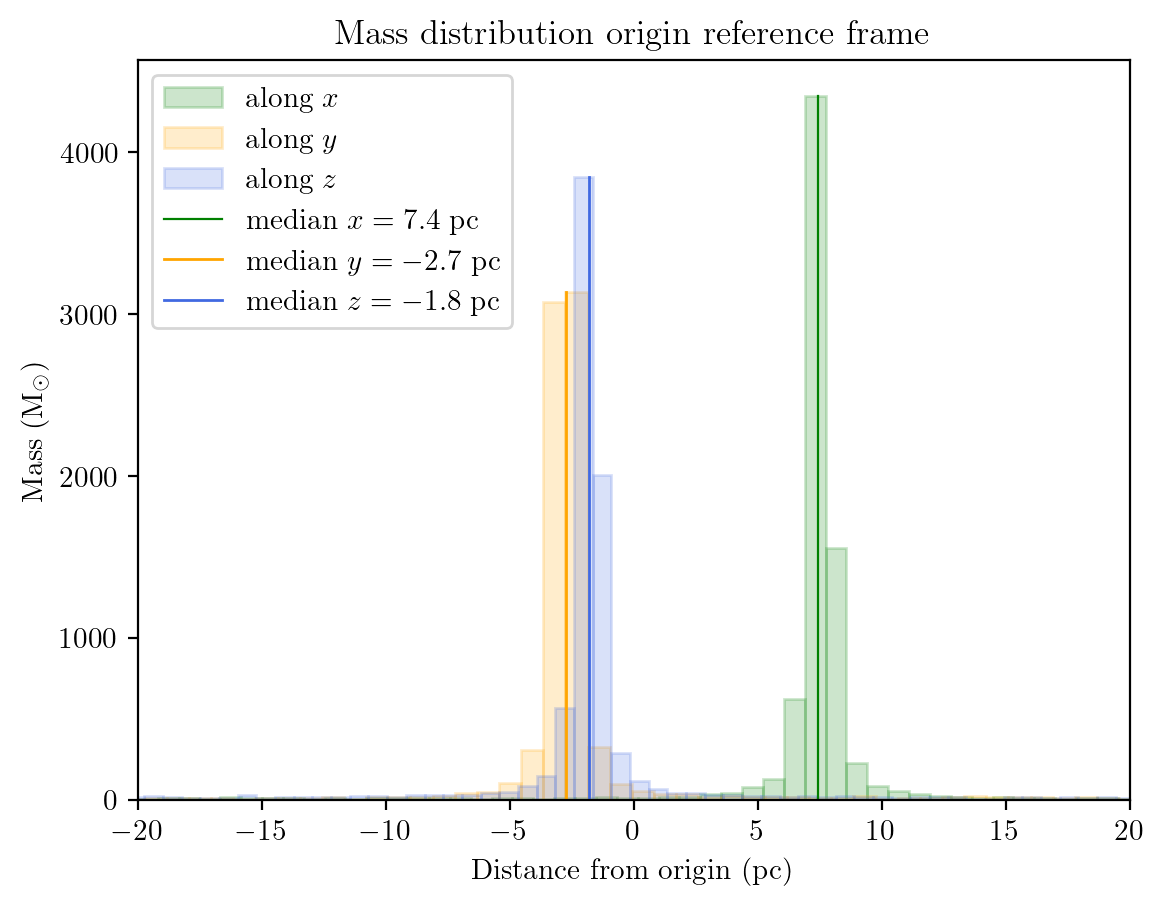

In [481]:
num = int(len(pl.t)-1)
pl.plot_mass_distribution(num);

Let's now repeat this method but now having shifted the coordinates in the center of mass of the remnant. To do so we need to find a good definition for the center of mass.

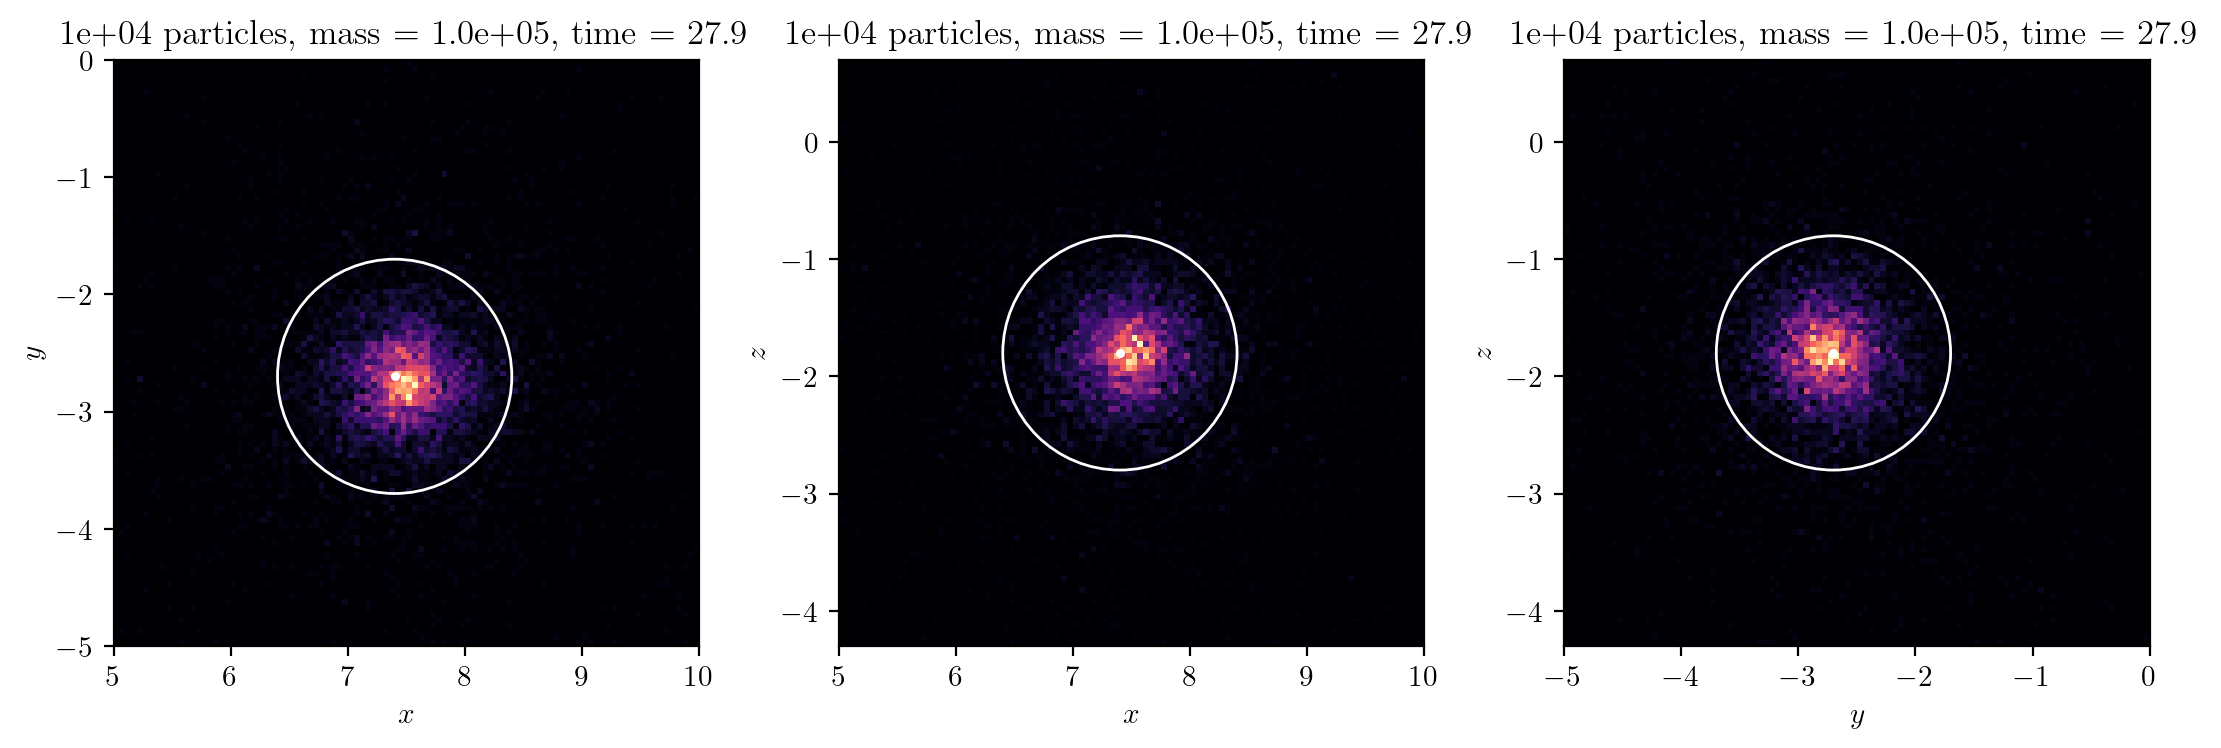

In [486]:
_,axs = pl.projections_heatmap(num, x_min=5, y_min=-5, z_min=-4.3, l=5)

x_c, y_c, z_c = 7.4, -2.7, -1.8
r = 1

centers = [(x_c, y_c), (x_c, z_c), (y_c, z_c)]
for i, (center, ax) in enumerate(zip(centers, axs)):
    circle = plt.Circle(center, radius=r, color='w', fill=False)
    ax.add_patch(circle)
    ax.scatter(*center, color='w', s=5)

Graphically we can see this resembles a spheroidal object, we can calculate its center and radius as follows

In [488]:
# i compute the center of mass for those points whose distance from the center i graphically found is less than the radius
mask = gdsam.distance(pl.x[:,num], pl.y[:,num], pl.z[:,num],
                      x_c, y_c, z_c) < r

m, x, y, z = pl.m[mask], pl.x[mask], pl.y[mask], pl.z[mask]

x_cm, y_cm, z_cm = gdsam.center_of_mass(x,y,z,m)

print(f'The remnant center of mass is roughly at position {x_cm[num]:.2f}, {y_cm[num]:.2f}, {z_cm[num]:.2f}')

The remnant center of mass is roughly at position 7.48, -2.73, -1.80


In [ ]:
num = int(len(pl.t) - 1)
axs = pl.projections_heatmap(num, x_min=5, y_min=-5, z_min=-4.3, l=5)

x_c, y_c, z_c = x_cm[num], y_cm[num], z_cm[num]
r = 1

centers = [(x_c, y_c), (x_c, z_c), (y_c, z_c)]
for i, (center, ax) in enumerate(zip(centers, axs)):
    circle = plt.Circle(center, radius=r, color='w', fill=False)
    ax.add_patch(circle)
    ax.scatter(*center, color='w', s=5)

Now we can see how particles are distributed in the remnant center of mass reference frame

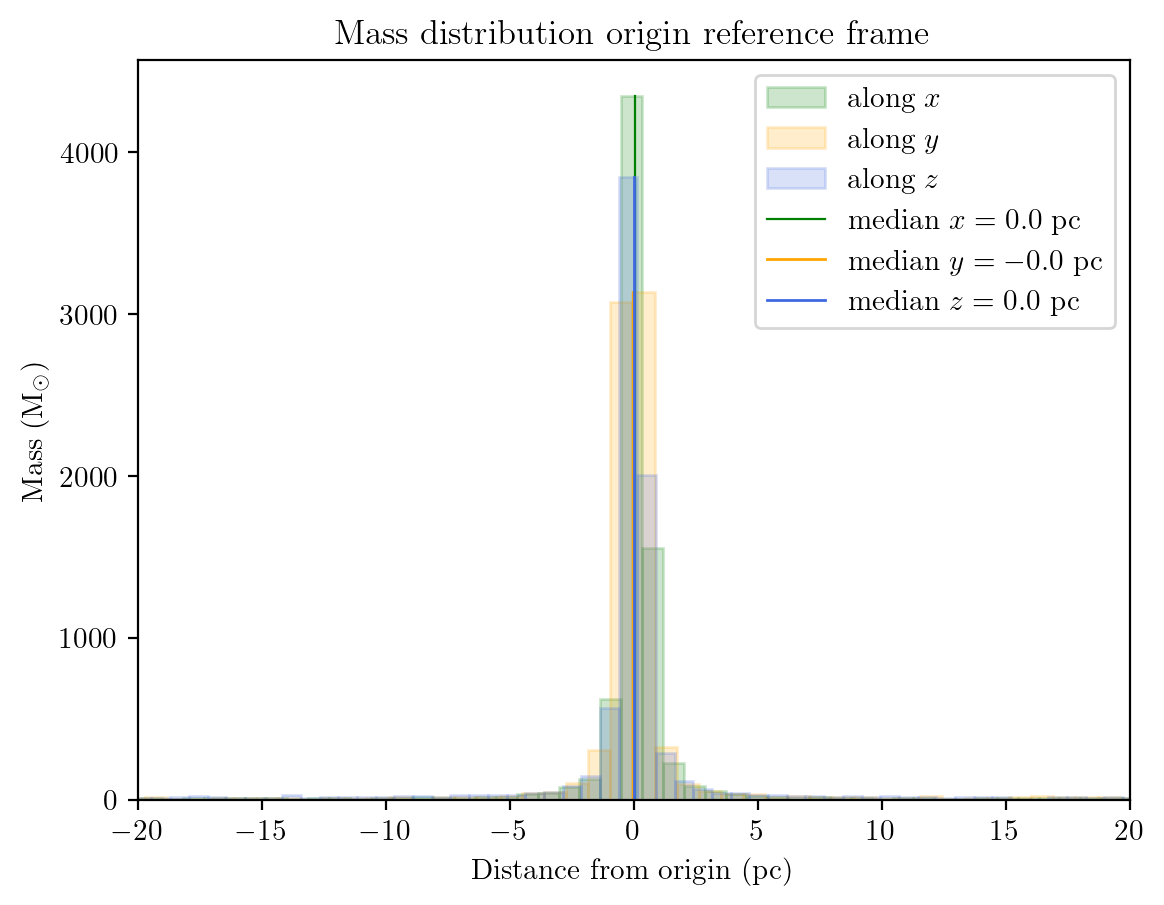

In [483]:
x_ = pl.x - x_c
y_ = pl.y - y_c
z_ = pl.z - z_c
pl.plot_mass_distribution(num, x_, y_, z_);

We can also have a look at the radial, polar and azimuthal mass distribution.
To do so we need to find the correct transformation

$$
\begin{cases}
x = r\sin(\theta)\sin(\phi)\\
y = r\sin(\theta)\cos(\phi)\\
z = r\cos(\theta)\\
\end{cases}
$$

The inverse transformation is

$$
\begin{cases}
r^2 = x^2 + y^2 + z^2 \\
\cos(\theta) = z/r \\
\sin(\phi) = \dfrac{x}{r\sin(\theta)} = \dfrac{x}{r\sqrt{1 - z^2/r^2}}
\end{cases}
$$

therefore

$$
\begin{cases}
r = \sqrt{x^2 + y^2 + z^2} \\[1em]
\theta = \arccos(z/r) \\[1em]
\phi = \arcsin\left(\dfrac{x}{\sqrt{x^2+y^2}}\right)
\end{cases}
$$

In [484]:
# in the new reference frame the origin x_c,y_c,z_c is now 0,0,0
radius=5

r_ = gdsam.distance(x_, y_, z_, 0,0,0)[:,num]
mask = r_ < radius

theta_c = np.arccos(z_[:,num]/r_)[mask]
phi_c = 2*np.arcsin(x_[:,num]/np.sqrt(x_[:,num]**2 + y_[:,num]**2))[mask] # i added this 2 to get phi = [-pi,pi] but why??
r_ = r_[mask]

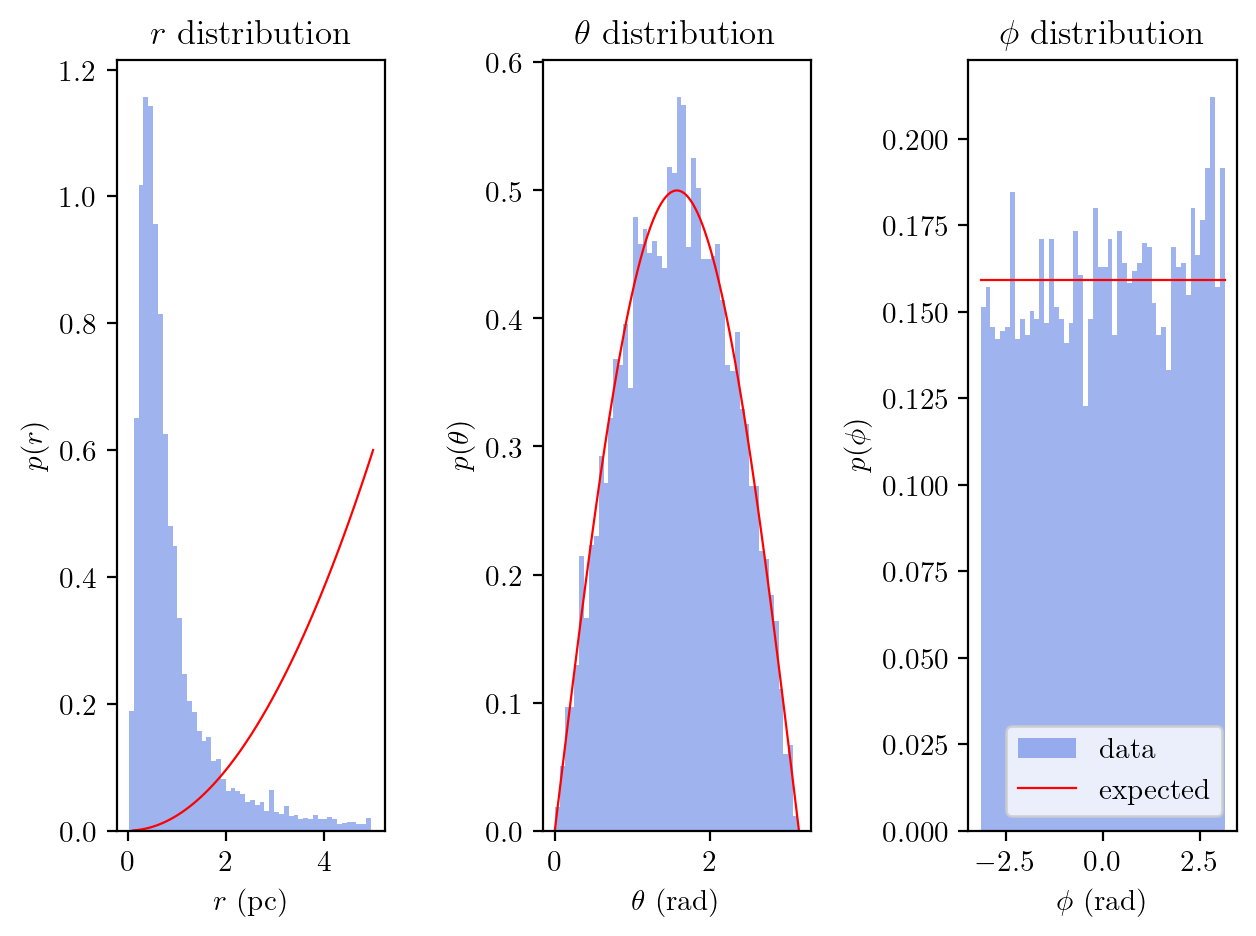

In [24]:
b = 50

fig, axs = plt.subplots(1, 3, tight_layout=True, sharey=False)
axs[0].set(title=fr'$r$ distribution', xlabel=r'$r$ (pc)', ylabel=r'$p(r)$')
axs[0].hist(r_, bins=b, density=True, alpha=.5, color='royalblue', lw=0)
axs[1].set(title=fr'$\theta$ distribution', xlabel=r'$\theta$ (rad)', ylabel=r'$p(\theta)$')
axs[1].hist(theta_c, bins=b, density=True, alpha=.5, color='royalblue', lw=0)
axs[2].set(title=fr'$\phi$ distribution', xlabel=r'$\phi$ (rad)', ylabel=r'$p(\phi)$')
axs[2].hist(phi_c, bins=b, density=True, alpha=.5, color='royalblue', lw=0, label='data')


prob_r = lambda x: 3*x**2/radius**3
prob_theta = lambda x: 0.5*np.sin(x)
prob_phi = lambda x: np.full(len(x), 1/(2*np.pi))  #why half the range? phi = -pi/2 to pi/2

r_t = np.linspace(0.1, radius, 100)
theta_t = np.linspace(0,np.pi, 100)
phi_t = np.linspace(-np.pi,np.pi, 100)

axs[0].plot(r_t, prob_r(r_t), c='r', lw=.8)
axs[1].plot(theta_t, prob_theta(theta_t), c='r', lw=.8)
axs[2].plot(phi_t, prob_phi(phi_t), c='r', label='expected', lw=.8)

plt.legend(loc='lower right');

Would this fit a plummer model?

Now let's calculate the lagrangian radii in this new reference frame

In [25]:
def l_radii(r, q):
    L_radii = []

    for i in range(len(r[0])):
                radii_sorted = np.sort(r[:,i])
                mask = radii_sorted < np.quantile(radii_sorted, q)
                L_radii.append(np.max(radii_sorted[mask]))

    return L_radii

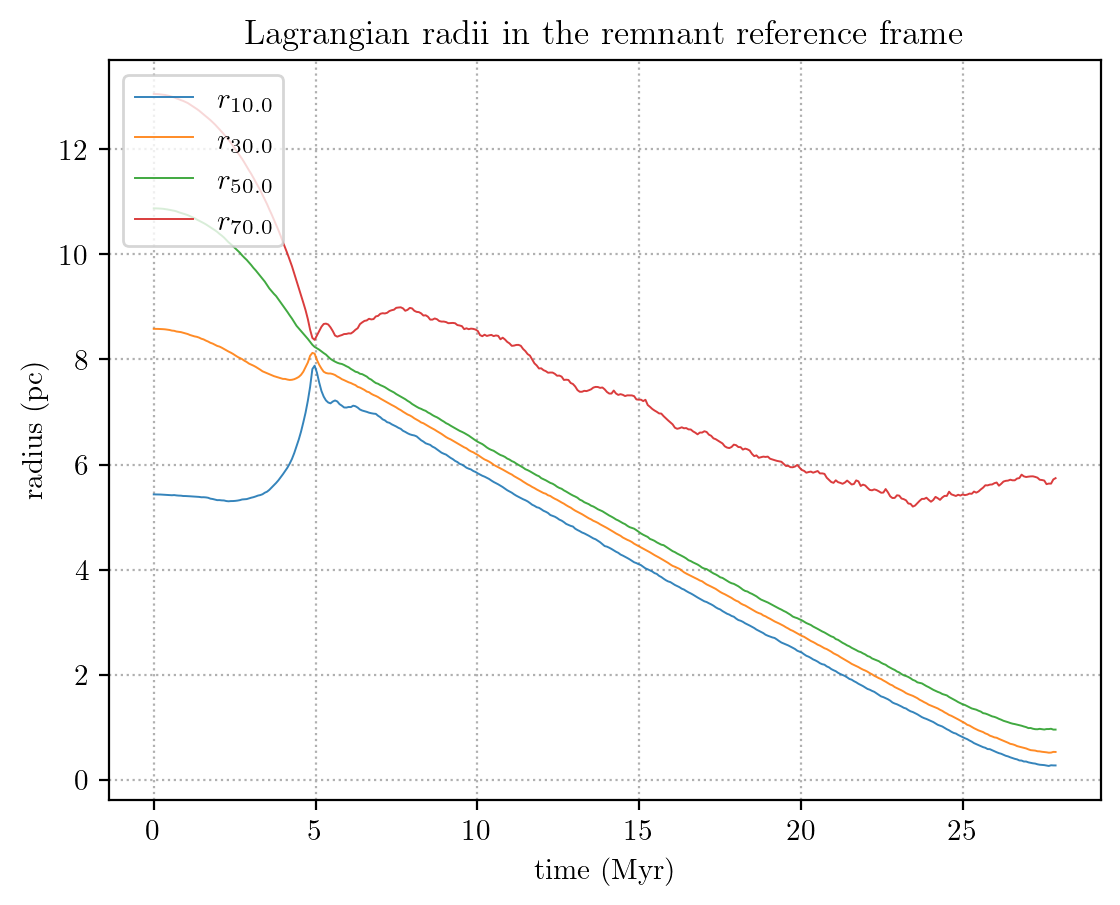

In [26]:
qtile = np.linspace(0.1,.7,4)
r_ = gdsam.distance(x_, y_, z_, 0,0,0)

for q in qtile:
    plt.plot(pl.t, l_radii(r_,q),lw=.7, alpha=.9,
             label=fr'$r_{{{q*100:.1f}}}$')

plt.xlabel('time (Myr)')
plt.title('Lagrangian radii in the remnant reference frame')
plt.ylabel('radius (pc)')
plt.grid()
plt.legend(loc='upper left');

As time progresses the remnant keeps on contracting, the new cluster relaxes onto a new equilibrium configuration and gradually exchanges kinetic energy for potential energy. We can see that towards the end the radius seems to become constant. This is the result of the stable equilibrium, the remnant is not contracting anymore.

### Energy/Angular momentum conservation

In [27]:
d = pl.get_log_tree(f'../../data/outputs/hom_sph_{N}_log.txt')
d.keys()

dict_keys(['time', '|T+U|', 'T', '-U', '-T/U', '|Vcom|', '|Jtot|', 'CPUtot'])

For the units of energy we need the following conversion:
E = $1\mathrm{erg}$ = $1\mathrm{g\cdot cm}^2 s^{-2}$ 
We have already done the conversion, so for our units
$$
E = 1\mathrm{M_\odot\cdot pc^2 Myr^{-2}} = \mathrm{2\times10^{33}g\cdot (3\times10^{18}\ cm)^2 (3.15\times 10^{7} \times 10^{6}\ s)^{-2}} = 2\times 10^{43}\ \mathrm{erg}
$$

$$
J = 1\mathrm{M_\odot\cdot pc^2 Myr^{-1}} = \mathrm{2\times10^{33}g\cdot (3\times10^{18}\ cm)^2 (3.15\times 10^{7} \times 10^{6}\ s)^{-1}} = 6\times 10^{56}\ \mathrm{erg\cdot s}
$$

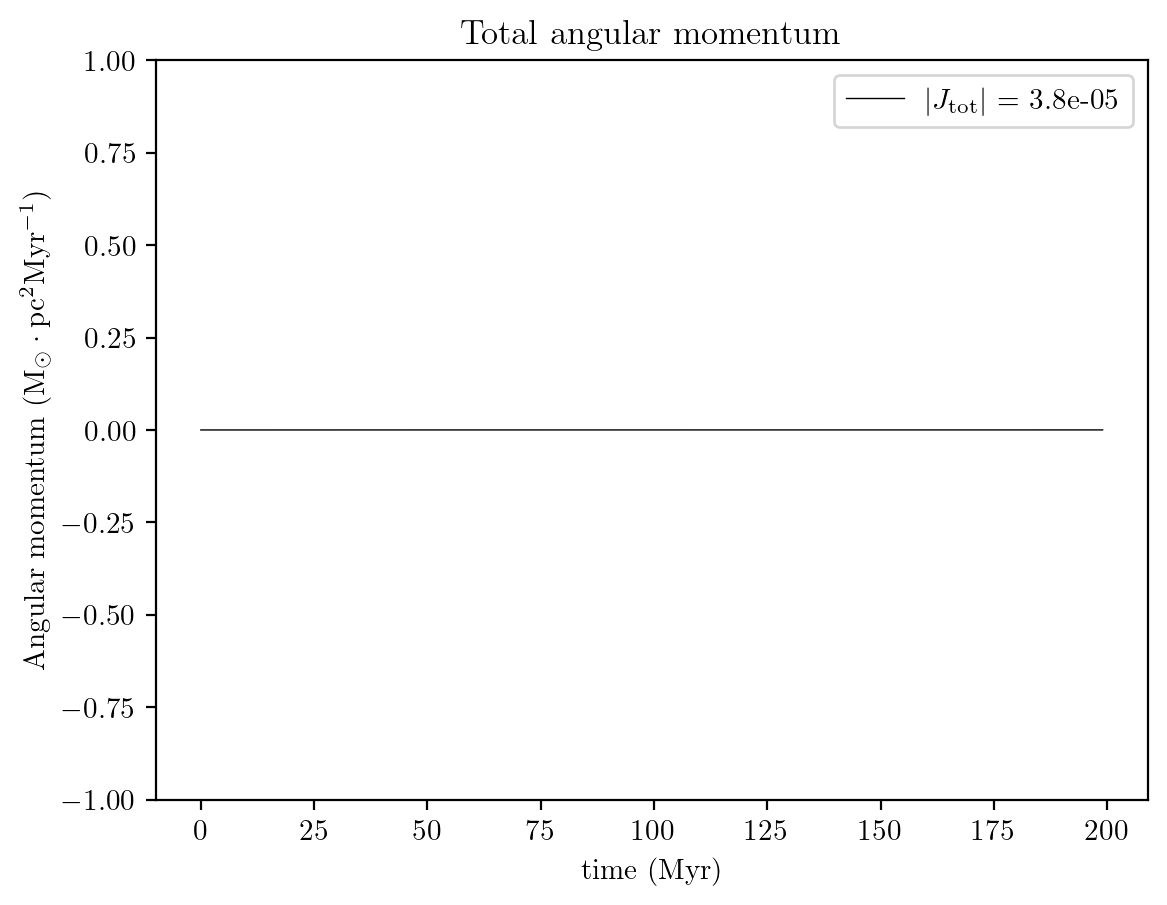

In [28]:
J = np.average(list(d['|Jtot|'].values()))

plt.plot(d['time'].values(),d['|Jtot|'].values(), lw=.5, c='k',
        label = fr'$|J_\mathrm{{tot}}|$ = {J:.1e}')
plt.title('Total angular momentum')
plt.ylim(-1,1)
plt.legend()
plt.xlabel(r'time (Myr)')
plt.ylabel(r'Angular momentum ($\mathrm{M_\odot\cdot pc^2 Myr^{-1}}$)');

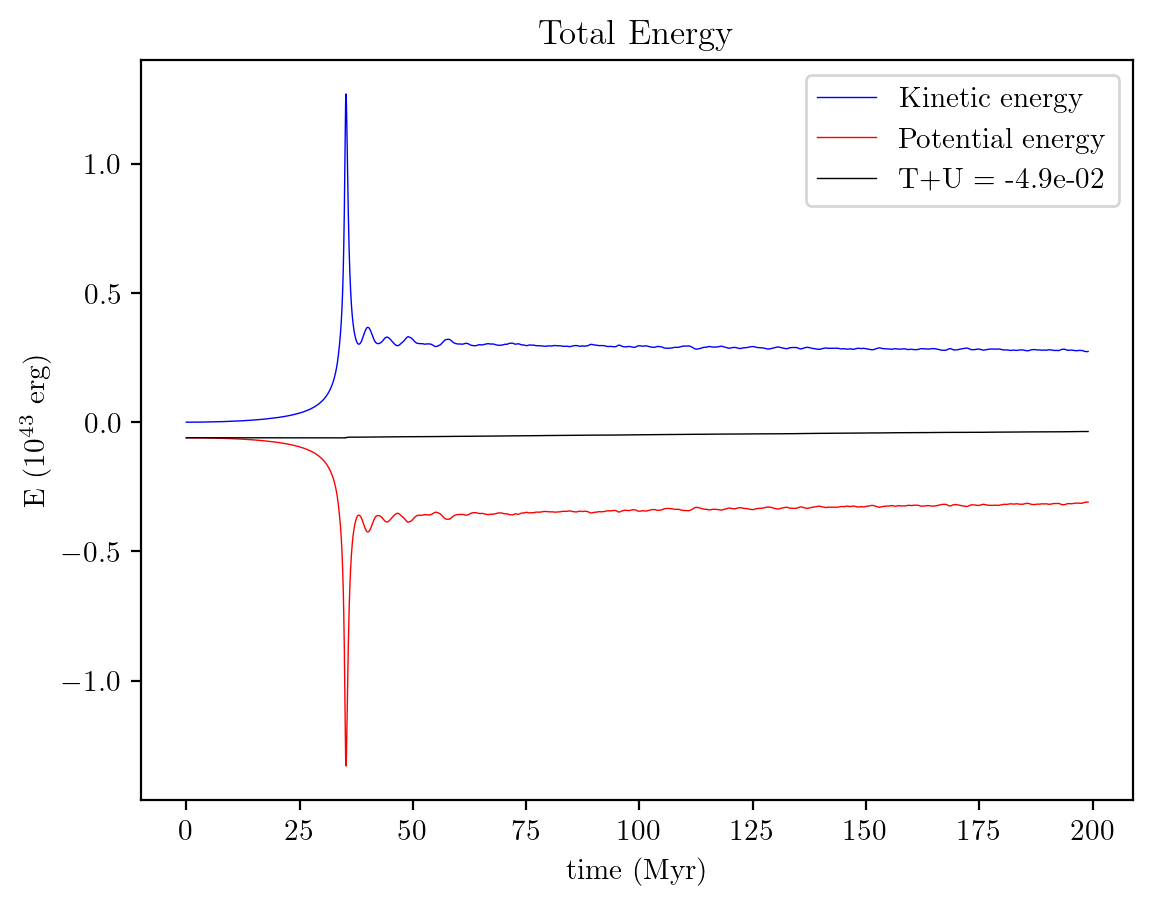

In [40]:
T = np.array([t for t in d['T'].values()])
U = np.array([-u for u in d['-U'].values()])

plt.plot(d['time'].values(),T, lw=.5, c='b', label='Kinetic energy')
plt.plot(d['time'].values(),U, lw=.5, c='r', label='Potential energy')
plt.plot(d['time'].values(),T+U, lw=.5, c='k', label=f'T+U = {np.average(T+U):.1e}')
plt.title('Total Energy')
plt.xlabel(r'time (Myr)')
plt.ylabel(r'E ($10^{43}$ erg)')


plt.legend();

### Conclusions (Dotti)
- The collapse time improves increasing the number of points
- Time of collapse increases faster than $N^2$ for `nbody_sh1` simulations
- Scatterings happen between pairs of particles on average
- At the end a bound central structure forms, we called it remnant. It's dynamical state is hard to predict, it seems as if it is oscillating about a stable equilibrium

In the case of the remnant, this behaviour is expected due to energy conservation.

In theory, the process of a remnant core formation should keep going and matter should keep on evaporating.

#### <u> Argument about binaries and stability </u>

If instead within the core you start forming binaries, those act as a leading term to the potential energy. This stops the collapse, since if a particle approaches such binaries, the most likely behaviour is that the foreigner gets scattered away.
This is unlikely for globular clusters, so we will discuss results without talking about the binary case.


#### <u> Violent relaxation process </u>

**If you perturb the spherical symmetry of the system during the collapse, the result isn't a plsimilar collapse anymore.** The evolution results in an exchange of energy between particles mediated by the global potential of the system. This is the so called **violent relaxation process**.

By relaxation we mean some physical process that transfers energy allowing to go towards the most probable state (e.g. scattering between molecules of a gas is the relaxation process that allows molecules to go towards being maxwellian distributed)

The adjective *violent* comes from the fact that in this cases the gravitational potential $\phi$ evolves on timescales of about the **dynamical time of the system**. This is our case.

#### <u> Analysis of the collapse </u>
During the collapse a particle gets scattered with a larger velocity than the initial one, its velocity depends on its distance from the center. Therefore it is more probable that a particle at large radius becomes unbounded after the collapse and viceversa.



